# Trying with using max over outputs

In [1]:
%load_ext autotime

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.densenet import DenseNet121
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import optimizers
from keras import metrics
from keras import models

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


from pathlib import Path
import pickle

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


time: 1.16 s


In [3]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 755 ms


In [4]:
import utils # importing from our utils functions

time: 4.25 s


In [5]:
from utils.paralleldensenet121 import ParallelDenseNet121

time: 5.73 ms


In [6]:
from keras.layers import merge

time: 4.92 ms


In [7]:
parallel_dense = ParallelDenseNet121(classes=1, nchannels=1, input_size=256, num_gpu=2)

time: 42.3 s


In [8]:
plot_model(parallel_dense)

time: 2.21 s


In [ ]:
parallel_dense.summary()

In [10]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 2.18 s


In [11]:
x_train.shape

(36808, 256, 256)

time: 1.76 ms


In [12]:
size = x_train.shape[1]

time: 3.86 ms


In [13]:
with Path('./data/MURA-v1.1/train_groups.pkl').open('rb') as pkl_file:
    train_groups = pickle.load(pkl_file)

time: 14.7 ms


In [14]:
n_studies = train_groups.groupby(['body_part', 'patient_id', 'study_id'])[0].count().count()

time: 8.96 ms


In [15]:
train_indices = train_groups.reset_index().groupby(['body_part', 'patient_id', 'study_id'])['index'].min().reset_index().sort_values('index').reset_index(drop=True)

time: 13.7 ms


In [16]:
train_indices.head()

,body_part,patient_id,study_id,index
0,shoulder,1,1,0
1,shoulder,2,1,3
2,shoulder,3,1,6
3,shoulder,4,1,9
4,shoulder,5,1,13


time: 7.8 ms


In [17]:
x_train_study = np.zeros(shape=(n_studies, size, size, 4))
y_train_study = np.zeros(shape=(n_studies,))

time: 869 µs


In [18]:
print(x_train_study.shape)
print(y_train_study.shape)

(13457, 256, 256, 4)
(13457,)
time: 2.1 ms


In [19]:
for i in range(n_studies):
    cur_index = train_indices.iloc[i]['index']
    if i < n_studies - 1:
        next_study_index = train_indices.iloc[i+1]['index']
    else:
        next_study_index = x_train.shape[0]
    for j in range(4):
        if cur_index < next_study_index:
            x_train_study[i, :, :, j] = x_train[cur_index, :, :]
            y_train_study[i] = y_train[cur_index]
        else:
            break
        cur_index = cur_index + 1

time: 12.7 s


In [20]:
del x_train, y_train
import gc; gc.collect()

264260

time: 558 ms


Double checking if images are correct

1.0


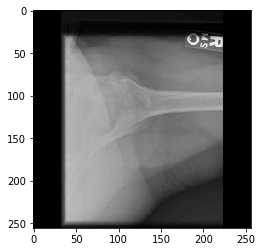

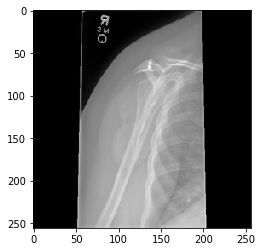

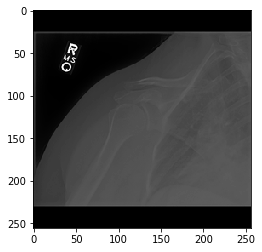

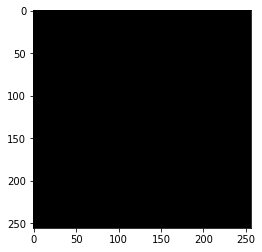

time: 355 ms


In [21]:
print(y_train_study[0])
for j in range(4):
    plt.imshow(x_train_study[0, :, :, j], cmap='gray')
    plt.show()

In [22]:
adam = optimizers.Adam()# amsgrad=True)

time: 12.8 ms


In [23]:
sgd = optimizers.SGD(lr=0.1, momentum=0.9)

time: 8.06 ms


In [24]:
parallel_dense.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=[metrics.binary_accuracy])

time: 31 ms


Write image generator

In [25]:

def preprocess_images(images, datagen):
    X = np.zeros((len(images), images[0].shape[0], images[0].shape[1], 1))
    for i, image in enumerate(images):
        X[i, :, :, :] = datagen.random_transform(image)
    return X

def quad_image_generator(input_x, input_y, batch_size, imgsize=256):
    datagen_args = dict(rotation_range=360,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.05,
        zoom_range=[1, 1.2],
        fill_mode = 'constant',
        cval=0,
        horizontal_flip=True,
        vertical_flip=True)
    datagens = [None] * 4
    for j in range(4):
        datagens[j] = ImageDataGenerator(**datagen_args)
        # datagens[j].fit(np.reshape(input_x[:, :, :, j], (n_studies, size, size, 1)))
        
    X = [None] * 4
    while True:
        # loop once per epoch
        num_recs = len(input_x)
        indices = np.arange(num_recs) # np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            # loop once per batch
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [input_x[i, :, :, :] for i in batch_indices]
            # make sure image data generators generate same transformations
            for j in range(4):
                X[j] = preprocess_images(
                    [np.reshape(
                        b[:, :, j], (imgsize, imgsize, 1)) 
                     for b in batch], datagens[j])
            Y = np.array([input_y[i] for i in batch_indices])
            yield X, Y

time: 3.98 ms


In [26]:
imgen = quad_image_generator(x_train_study, y_train_study, batch_size=20)

time: 2.52 ms


In [ ]:
parallel_dense.fit_generator(imgen, steps_per_epoch = len(x_train_study) / 20, epochs=100, verbose=2)

Epoch 1/100
 - 616s - loss: 0.5235 - binary_accuracy: 0.7579
Epoch 2/100


# Diagnose

In [27]:
X, Y = imgen.__next__()

time: 407 ms


In [28]:
X[1].shape

(20, 256, 256, 1)

time: 1.61 ms


In [29]:
X[0][0, :, :, 0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

time: 3.78 ms


In [30]:
i=4

time: 726 µs


In [31]:
Y[i]

1.0

time: 4.99 ms


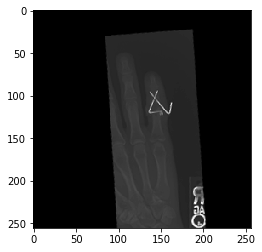

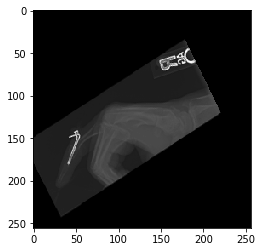

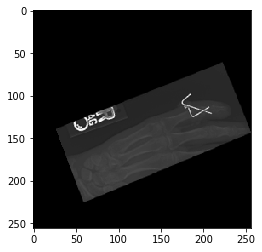

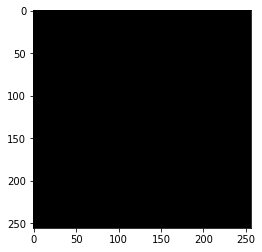

time: 506 ms


In [32]:
for j in range(4):
    plt.imshow(X[j][i, :, :, 0], cmap='gray')
    plt.show()

In [9]:
lyr = parallel_dense.get_layer('prob')
lyr.activation

<function keras.activations.sigmoid(x)>

time: 19.6 ms


In [34]:
last_layer = models.Model(input=parallel_dense.input, output=[parallel_dense.get_layer('prob').get_output_at(j) for j in range(4)])

time: 755 ms


In [40]:
llyr = last_layer.predict(X)

time: 284 ms


In [41]:
llyr

[array([[1.9595468],
        [1.9595456],
        [1.9595482],
        [1.9595456],
        [1.9595468],
        [1.8895068],
        [1.0477526],
        [1.9595506],
        [1.9595475],
        [1.9596124],
        [1.9595461],
        [1.9595459],
        [1.9595459],
        [1.1385181],
        [1.9595454],
        [1.9595487],
        [1.9595456],
        [1.8335991],
        [1.9595463],
        [1.9595494]], dtype=float32), array([[1.9595487],
        [1.9595456],
        [1.9595492],
        [1.9595456],
        [1.9595454],
        [1.9595485],
        [1.9596274],
        [0.553071 ],
        [1.9595456],
        [1.0609684],
        [1.9595466],
        [1.9595454],
        [1.9595456],
        [1.9595454],
        [1.9595459],
        [1.9595444],
        [1.9595463],
        [1.9595463],
        [1.9595459],
        [1.9513025]], dtype=float32), array([[1.9595487],
        [1.9595487],
        [1.9595473],
        [1.9595456],
        [1.9595454],
        [1.9595456],
  

time: 8.27 ms


In [36]:
Y_hat = parallel_dense.predict(X)

time: 7.76 s


In [37]:
Y_hat

array([[1.9595487],
       [1.9595487],
       [1.9595492],
       [1.9595456],
       [1.9595468],
       [1.9595485],
       [1.9596274],
       [1.9595506],
       [1.9595475],
       [1.9596124],
       [1.9595466],
       [1.9595459],
       [1.9595459],
       [1.9595459],
       [1.9595459],
       [1.9595487],
       [1.9595463],
       [1.9595475],
       [1.959547 ],
       [1.9595494]], dtype=float32)

time: 2.27 ms


In [47]:
Y

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

time: 4.62 ms


In [ ]:
parallel_dense.summary()